<a href="https://colab.research.google.com/github/dejuakim/PROJECT_aiffel/blob/master/House_Price_Prediction_MainQuest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# House Prices Prediction
Ames 시 주택 가격을 예측하는 모델
만들기
- 예측할 값(y): `SalePrice`
- 모델 평가 지표 : `RMSE` (Root mean sqaured error)

## 1단계. 데이터 이해 및 탐색 (EDA)
- Target 변수 확인
- 상관관계 분석
- 시각화

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 데이터 불러오기
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# 데이터 크기 확인
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

# 상위 5개 행 확인
train_df.head()

Train Data Shape: (1168, 81)
Test Data Shape: (292, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000
3,239,20,RL,93.0,12030,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2007,New,Partial,318000
4,891,50,RL,60.0,8064,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,2000,7,2007,WD,Normal,122900


### 타겟 변수 확인

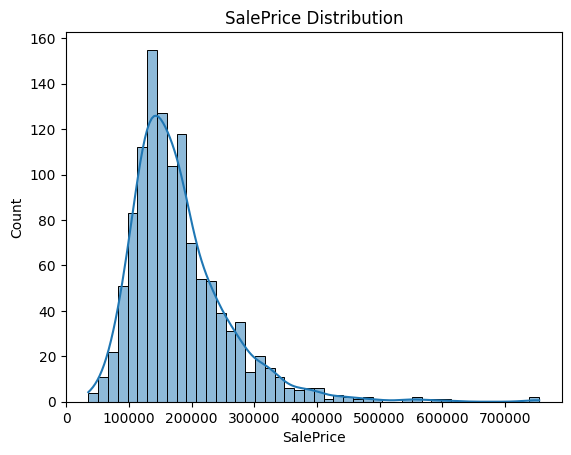

Skewness: 1.96
Kurtosis: 7.41


In [2]:
# 타겟 변수 시각화
# SalePrice 히스토그램
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()

# 왜도(Skewness)와 첨도(Kurtosis) 확인
print(f"Skewness: {train_df['SalePrice'].skew():.2f}")
print(f"Kurtosis: {train_df['SalePrice'].kurt():.2f}")

그래프의 봉우리가 왼쪽으로 쏠려있고 오른쪽으로 꼬리가 긴 형태입니다. 대부분의 집들은 평균 가격대에 몰려 있지만 아주 비싼 초 고가의 집들이 존재하는 것으로 보입니다.

현재 상태로 학습 시 모델이 고가 주택의 가격을 예측할 때 오차가 커질 가능성이 있어보여 로그 변환을 해주겠습니다.

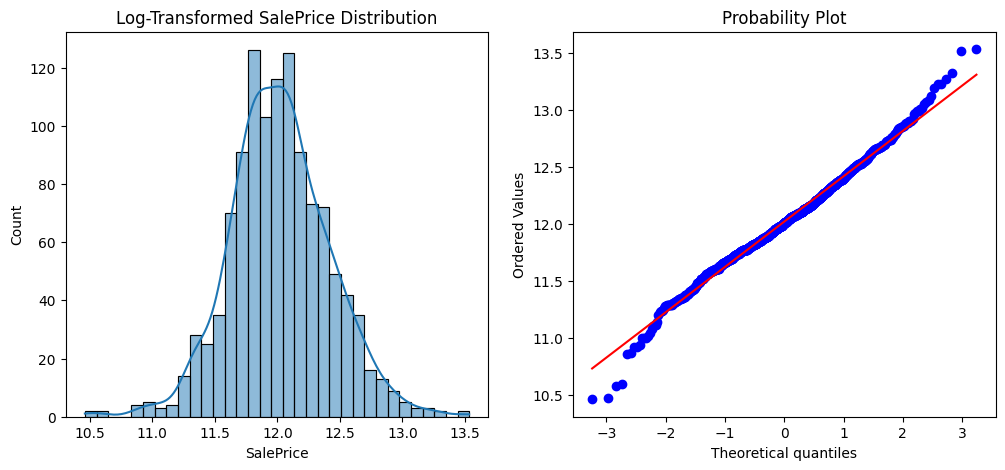

변환 후 왜도: 0.09


In [3]:
# 로그 변환 적용
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

# 변환 후 분포 시각화
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Log-Transformed SalePrice Distribution')

plt.subplot(1, 2, 2)
from scipy import stats
stats.probplot(train_df['SalePrice'], plot=plt) # Q-Q plot 확인
plt.show()

print(f"변환 후 왜도: {train_df['SalePrice'].skew():.2f}")

### 상관관계 분석

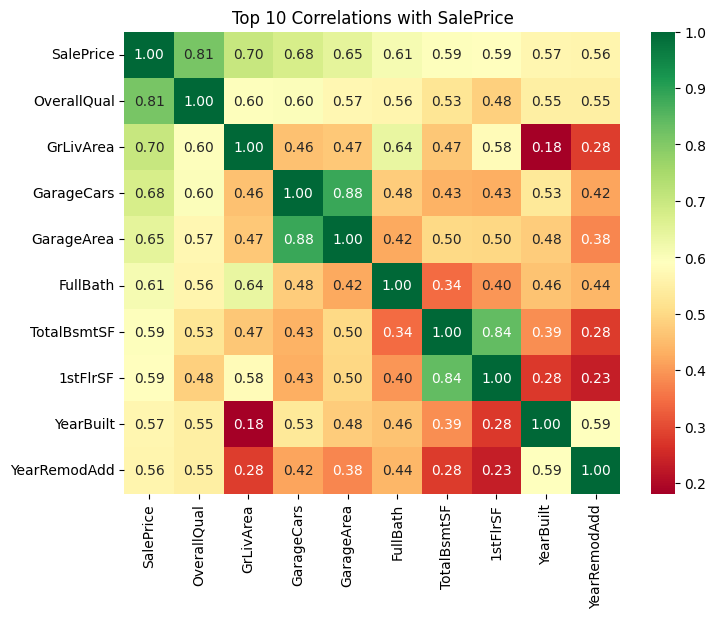

In [4]:
# 수치형 데이터만 선택
numeric_features = train_df.select_dtypes(include=[np.number])

# 상관관계 계산
corr = numeric_features.corr()

# SalePrice와 상관관계가 높은 상위 10개 변수 추출
cols = corr.nlargest(10, 'SalePrice')['SalePrice'].index

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(train_df[cols].corr(), annot=True, cmap='RdYlGn', fmt='.2f')
plt.title('Top 10 Correlations with SalePrice')
plt.show()

SalePrice와 가장 밀접한 상위 변수들
- OverallQual (0.81): 집의 전반적인 품질이 가격 결정의 핵심
- GrLivArea (0.70): 지상 거주 면적으로 집이 넓을수록 고가
- GarageCars (0.68) & GarageArea (0.65): 차고의 크기가 집값에 큰 영향
- TotalBsmtSF (0.59) & 1stFlrSF (0.59): 지하 면적과 1층 면적

다중공선성 확인
- GarageCars & GarageArea (0.88): 거의 같은 정보를 담고 있음
- TotalBsmtSF & 1stFlrSF (0.84): 보통 지하 면적이 넓으면 1층 면적도 넓기 때문에 높은 상관관계를 보임

## 2단계: 데이터 전처리 (Data Cleaning)
- 이상치 확인 및 전처리
- 결측치 확인 및 전처리
- 인코딩

### 이상치 확인 및 전처리

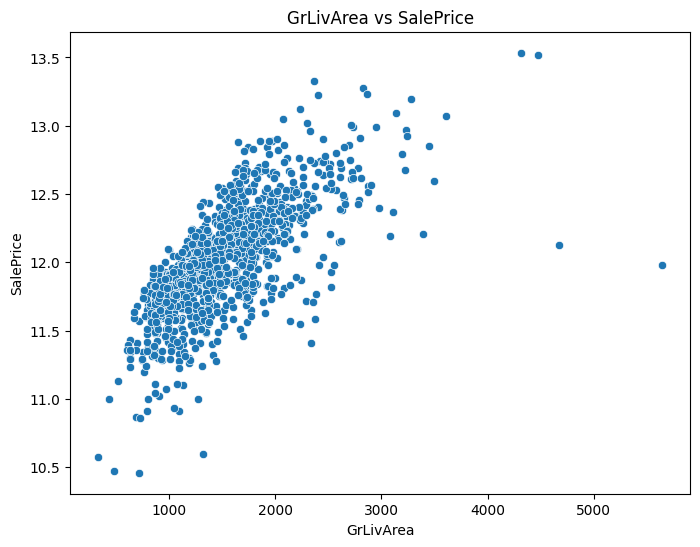

In [5]:
# 이상치 확인
# GrLivArea와 SalePrice의 관계
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.title('GrLivArea vs SalePrice')
plt.show()

상관관계가 가장 높았던 변수 중 하나인 GrLivArea를 기준으로 이상치를 확인했더니 엄청 넓은데 가격이 낮은 데이터가 2개 보입니다.

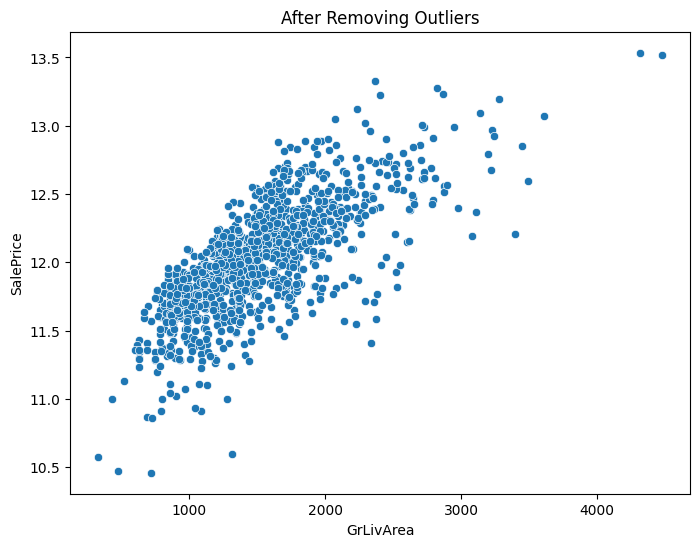

In [6]:
# 이상치 제거(GrLivArea가 4000보다 크지만 SalePrice가 낮은 데이터)
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 12.5)].index)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.title('After Removing Outliers')
plt.show()

### 결측치 확인 및 전처리

In [7]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

In [8]:
# 전체 데이터 통합
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [9]:
# 결측치 개수와 비율 계산
all_na = (all_data.isnull().sum() / len(all_data)) * 100
all_na = all_na.drop(all_na[all_na == 0].index).sort_values(ascending=False)

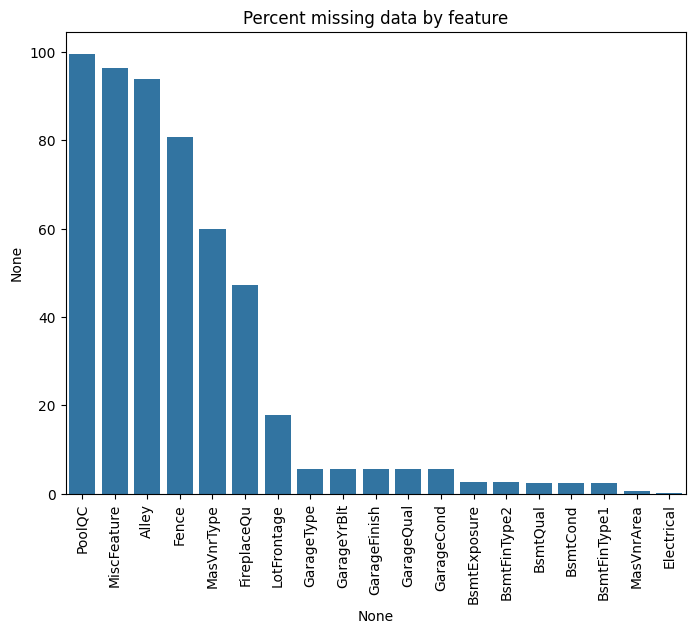

결측치가 있는 변수 개수: 19


In [10]:
# 결측치 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x=all_na.index, y=all_na)
plt.xticks(rotation=90)
plt.title('Percent missing data by feature')
plt.show()

print(f"결측치가 있는 변수 개수: {len(all_na)}")

PoolQC, MiscFeature, Alley, Fence는 대부분의 데이터가 비어 있습니다.

PoolQC, MiscFeature, Alley, Fence는 대부분의 집에 존재하지 않는 시설들로 집값에 영향을 줄 수 있는지 확인해봅니다.

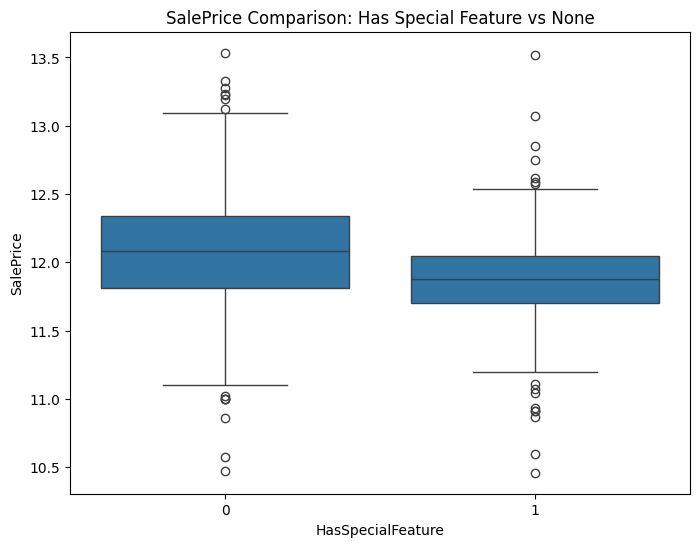

In [11]:
# 시설이 하나라도 있으면 1, 없으면 0
features_to_check = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
temp_data = train_df.copy()

temp_data['HasSpecialFeature'] = temp_data[features_to_check].fillna('None').apply(
    lambda x: 1 if any(val != 'None' for val in x) else 0, axis=1
)

# 박스플롯 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='HasSpecialFeature', y='SalePrice', data=temp_data)
plt.title('SalePrice Comparison: Has Special Feature vs None')
plt.show()

해당 변수들은 삭제하더라도 큰 영향이 없는 것으로 보임

In [12]:
# Null이 너무 많은 컬럼과 불필요한 컬럼 삭제
all_data.drop(['Id','PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [24]:
# Null값이 있는 컬럼과 건수, 타입 확인
null_info = pd.DataFrame({
    'Null Count': all_data.isnull().sum(),
    'Dtype': all_data.dtypes
})

# 결측치가 0보다 큰 컬럼만 필터링하여 내림차순 정렬
null_info = null_info[null_info['Null Count'] > 0].sort_values(by='Null Count', ascending=False)

null_info

,Null Count,Dtype
MasVnrType,872,object
FireplaceQu,690,object
LotFrontage,259,float64
GarageYrBlt,81,float64
GarageFinish,81,object
GarageType,81,object
GarageQual,81,object
GarageCond,81,object
BsmtExposure,38,object
BsmtFinType2,38,object


In [26]:
target_num_cols = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea', 'GarageCars', 'GarageArea']
all_data[target_num_cols].describe()

,LotFrontage,GarageYrBlt,MasVnrArea,GarageCars,GarageArea
count,1199.000000,1377.000000,1450.000000,1458.000000,1458.000000
mean,69.797331,1978.464052,102.753793,1.766118,472.050069
std,23.203458,24.682879,179.442156,0.747104,212.239248
min,21.000000,1900.000000,0.000000,0.000000,0.000000
25%,59.000000,1961.000000,0.000000,1.000000,331.500000
50%,69.000000,1980.000000,0.000000,2.000000,479.500000
75%,80.000000,2002.000000,164.750000,2.000000,576.000000
max,313.000000,2010.000000,1600.000000,4.000000,1390.000000


- MasVnrType (석조 베니어 유형)으로 석조 베니어가 없음을 의미할 확률이 높음
- MasVnrArea 는 석조 베니어가 없는 경우 이미 0으로 채워져 있는 것으로 보임
- FireplaceQu (벽난로 품질)은 벽난로가 없음을 의미할 확률이 높음
- LotFrontage(도로에 접한 토지 길이)는 조사가 누락된 것으로 볼 수 있음
- Garage Type, Finish, Qual, Cond 의 결측은 차고가 없는 집들
- GarageYrBlt (차고 건립 연도)는 차고가 없어서 연도가 없음
- Bsmt Exposure, Qual, Cond, FinType 등은 지하실이 없는 집
- Electrical(전기 시스템 종류) 1개의 결측치로 가장 흔한 유형으로 채우기


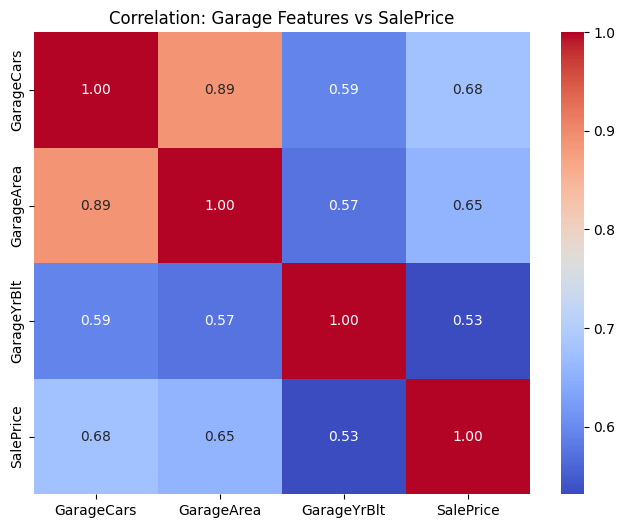

In [27]:
# 차고 관련 수치형 변수들 선택
garage_cols = ['GarageCars', 'GarageArea', 'GarageYrBlt', 'SalePrice']

# 상관관계 계산을 위한 임시 데이터프레임 (학습 데이터 기준)
garage_temp = all_data[:ntrain].copy()
garage_temp['SalePrice'] = train_df['SalePrice'].values

# 히트맵 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(garage_temp[garage_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation: Garage Features vs SalePrice')
plt.show()

In [28]:
# GarageArea 컬럼 삭제
all_data.drop('GarageArea', axis=1, inplace=True)

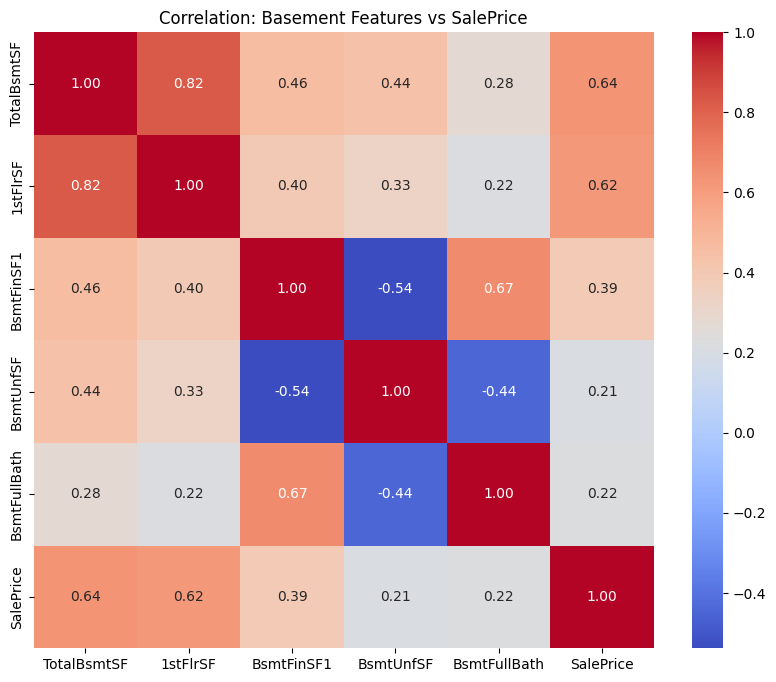

In [42]:
# 지하실 관련 주요 수치형 변수 선택
bsmt_num_cols = ['TotalBsmtSF', '1stFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'BsmtFullBath', 'SalePrice']

# 상관관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(temp_train[bsmt_num_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation: Basement Features vs SalePrice')
plt.show()

In [30]:
# 수치형 컬럼 0으로 채우기
numeric_cols = all_data.select_dtypes(include=['number']).columns
all_data[numeric_cols] = all_data[numeric_cols].fillna(0)

# 범주형 컬럼 None으로 채우기
object_cols = all_data.select_dtypes(include=['object']).columns
all_data[object_cols] = all_data[object_cols].fillna('None')

In [31]:
pd.set_option('display.max_columns', None)
all_data.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.00000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,56.893004,57.398491,10459.936900,6.093964,5.576132,1971.218107,1984.834019,102.189986,438.827160,46.613169,567.096708,1052.537037,1158.851166,345.762003,5.852538,1510.465706,0.423868,0.057613,1.563786,0.38203,2.866255,1.046639,6.510974,0.611111,1868.549383,1.766118,94.084362,46.245542,21.984225,3.414266,15.081619,2.433471,43.548697,6.323045,2007.816187
std,42.329437,33.983175,9859.198156,1.376369,1.113359,30.193754,20.641760,179.109864,432.969094,161.420729,442.087187,414.982320,372.039498,435.423924,48.655960,507.878508,0.517404,0.238907,0.549891,0.50271,0.816323,0.220483,1.615880,0.641988,453.979431,0.747104,125.350021,65.312932,61.155666,29.337173,55.792877,38.209947,496.460799,2.700167,1.328826
min,20.000000,0.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,42.000000,7544.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.250000,882.000000,0.000000,0.000000,1128.500000,0.000000,0.000000,1.000000,0.00000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,63.000000,9475.000000,6.000000,5.000000,1972.500000,1994.000000,0.000000,382.000000,0.000000,477.500000,991.000000,1086.000000,0.000000,0.000000,1461.500000,0.000000,0.000000,2.000000,0.00000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,0.000000,24.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,79.000000,11600.000000,7.000000,6.000000,2000.000000,2004.000000,163.750000,711.000000,0.000000,808.000000,1296.750000,1390.750000,728.000000,0.000000,1776.000000,1.000000,0.000000,2.000000,1.00000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,2188.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4476.000000,3.000000,2.000000,3.000000,2.00000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


LotFrontage는 시설이 아닌 도로와 맞닿은 길이로 0으로 채우면 집값 예측에 오류가 생길 수 있습니다. LotFrontage가 비어있는 것은 조사 시 누락되었을 확률이 큽니다.


먼저 동네마다 LotFrontage의 분포가 다른지 확인합니다.

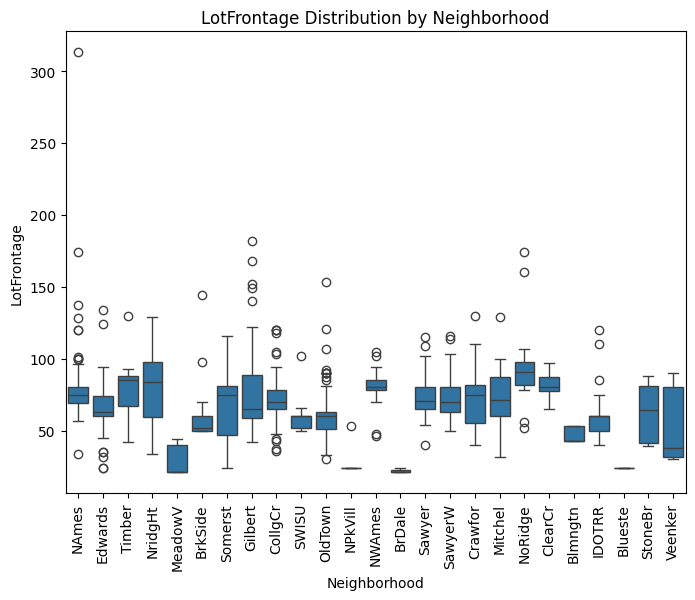

In [35]:
# 동네별 LotFrontage의 분포 확인
plt.figure(figsize=(8, 6))
sns.boxplot(x='Neighborhood', y='LotFrontage', data=train_df)
plt.xticks(rotation=90)
plt.title('LotFrontage Distribution by Neighborhood')
plt.show()

동네마다 도로의 길이가 다른 것을 확인할 수 있습니다.

현재 0으로 채워진 데이터가 얼마나 되는지 확인해보겠습니다.

In [36]:
print(f"현재 LotFrontage가 0인 데이터 수: {len(all_data[all_data['LotFrontage'] == 0])}")

현재 LotFrontage가 0인 데이터 수: 259


In [37]:
# replace를 사용하여 0을 NaN으로 바꾼 후 중앙값으로 다시 채워줍니다
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.replace(0, x.median())
)
len(all_data[all_data['LotFrontage'] == 0])

15

특정 동네의 모든 데이터가 0인 경우가 있었던 것으로 보입니다.
다시 동네별 중앙값을 먼저 채운 뒤 나머지 값들을 전체 데이터의 중앙값으로 한 번 더 채워주겠습니다.

In [38]:
# 0을 다시 NaN으로 되돌리기
all_data["LotFrontage"] = all_data["LotFrontage"].replace(0, np.nan)

# 동네별 중앙값으로 채우기
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# 남은 결측치(15개)는 전체 중앙값으로 채우기
all_data["LotFrontage"] = all_data["LotFrontage"].fillna(all_data["LotFrontage"].median())

# 최종 확인
print(f"최종 LotFrontage 결측치 수: {all_data['LotFrontage'].isnull().sum()}")
print(f"최종 LotFrontage가 0인 데이터 수: {len(all_data[all_data['LotFrontage'] == 0])}")

최종 LotFrontage 결측치 수: 0
최종 LotFrontage가 0인 데이터 수: 0


In [43]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1458 non-null   int64  
 1   MSZoning       1458 non-null   object 
 2   LotFrontage    1458 non-null   float64
 3   LotArea        1458 non-null   int64  
 4   Street         1458 non-null   object 
 5   LotShape       1458 non-null   object 
 6   LandContour    1458 non-null   object 
 7   Utilities      1458 non-null   object 
 8   LotConfig      1458 non-null   object 
 9   LandSlope      1458 non-null   object 
 10  Neighborhood   1458 non-null   object 
 11  Condition1     1458 non-null   object 
 12  Condition2     1458 non-null   object 
 13  BldgType       1458 non-null   object 
 14  HouseStyle     1458 non-null   object 
 15  OverallQual    1458 non-null   int64  
 16  OverallCond    1458 non-null   int64  
 17  YearBuilt      1458 non-null   int64  
 18  YearRemo

### 인코딩

In [45]:
all_data.describe()

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.00000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000,1458.000000
mean,69.106310,10459.936900,6.093964,1971.218107,1984.834019,102.189986,438.827160,46.613169,567.096708,1052.537037,1158.851166,345.762003,5.852538,1510.465706,0.423868,0.057613,1.563786,0.38203,2.866255,1.046639,6.510974,0.611111,1868.549383,1.766118,94.084362,46.245542,21.984225,3.414266,15.081619,2.433471,43.548697
std,21.603346,9859.198156,1.376369,30.193754,20.641760,179.109864,432.969094,161.420729,442.087187,414.982320,372.039498,435.423924,48.655960,507.878508,0.517404,0.238907,0.549891,0.50271,0.816323,0.220483,1.615880,0.641988,453.979431,0.747104,125.350021,65.312932,61.155666,29.337173,55.792877,38.209947,496.460799
min,21.000000,1300.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,60.000000,7544.500000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.250000,882.000000,0.000000,0.000000,1128.500000,0.000000,0.000000,1.000000,0.00000,2.000000,1.000000,5.000000,0.000000,1958.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,9475.000000,6.000000,1972.500000,1994.000000,0.000000,382.000000,0.000000,477.500000,991.000000,1086.000000,0.000000,0.000000,1461.500000,0.000000,0.000000,2.000000,0.00000,3.000000,1.000000,6.000000,1.000000,1977.000000,2.000000,0.000000,24.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,80.000000,11600.000000,7.000000,2000.000000,2004.000000,163.750000,711.000000,0.000000,808.000000,1296.750000,1390.750000,728.000000,0.000000,1776.000000,1.000000,0.000000,2.000000,1.00000,3.000000,1.000000,7.000000,1.000000,2001.000000,2.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,313.000000,215245.000000,10.000000,2010.000000,2010.000000,1600.000000,2188.000000,1474.000000,2336.000000,3206.000000,3228.000000,2065.000000,572.000000,4476.000000,3.000000,2.000000,3.000000,2.00000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000


- MSSubClas는 건물 등급으로 연산용 수치 아님
- OverallCond는 등급나타내는 것으로 연산용 수치 아님
- MoSold & YrSold 는 날짜
- LotArea는 표준편차가 10459로 로그변환이나 스케일링 고려
- MasVnrArea는 석조 베니어 면적으로 절반 이상이 0(대부분의 집에 없음)
- MiscVal & PoolArea는 75% 지점까지 0

In [46]:
# 비례관계 없는 수치형 변수 문자로 타입 변환
for col in ['MSSubClass', 'OverallCond', 'MoSold', 'YrSold']:
    if col in all_data.columns:
        all_data[col] = all_data[col].apply(str)

In [47]:
# 수치형 데이터 중 왜도(Skewness)가 높은 변수들 로그 변환
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = all_data[numeric_feats].apply(lambda x: x.skew()).sort_values(ascending=False)
high_skew = skewed_feats[abs(skewed_feats) > 0.75]

for feat in high_skew.index:
    all_data[feat] = np.log1p(all_data[feat])

범주형 변수 인코딩

In [48]:
# 범주형 변수들을 원-핫 인코딩
all_data = pd.get_dummies(all_data)
print(f"인코딩 후 데이터 형태: {all_data.shape}")

인코딩 후 데이터 형태: (1458, 321)


스케일링 진행

In [49]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

In [50]:
all_data_scaled = scaler.fit_transform(all_data)

In [52]:
# 학습 데이터와 테스트 데이터로 다시 분리
X_train = all_data_scaled[:ntrain]
X_test = all_data_scaled[ntrain:]
y_train = train_df.SalePrice

## 3단계: 모델 선택 및 학습 (Model Selection)

In [53]:
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# 모델 정의
lasso = Lasso(alpha=0.0005, random_state=42)
ridge = Ridge(alpha=10, random_state=42)
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05, max_depth=3, random_state=42)

# 성능 확인 함수 (RMSE 점수 반환)
def get_rmse_cv(model):
    # negative mean squared error를 사용하므로 -를 붙여줍니다.
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                    scoring="neg_mean_squared_error", cv=5))
    return rmse

# 3. 각 모델 실행 및 결과 저장
lasso_score = get_rmse_cv(lasso)
ridge_score = get_rmse_cv(ridge)
xgb_score = get_rmse_cv(xgb)

print(f"Lasso CV 평균 RMSE: {lasso_score.mean():.5f}")
print(f"Ridge CV 평균 RMSE: {ridge_score.mean():.5f}")
print(f"XGBoost CV 평균 RMSE: {xgb_score.mean():.5f}")

Lasso CV 평균 RMSE: 0.11299
Ridge CV 평균 RMSE: 0.11577
XGBoost CV 평균 RMSE: 0.12637


/tmp/ipython-input-967504145.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=results, palette='magma')


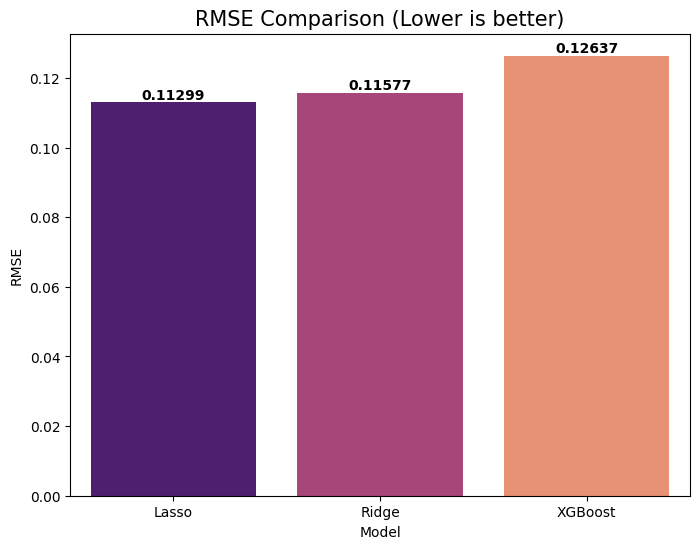

In [54]:
# 데이터프레임으로 정리
model_names = ['Lasso', 'Ridge', 'XGBoost']
rmse_means = [lasso_score.mean(), ridge_score.mean(), xgb_score.mean()]
results = pd.DataFrame({'Model': model_names, 'RMSE': rmse_means})

# 시각화
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='RMSE', data=results, palette='magma')
plt.title('RMSE Comparison (Lower is better)', fontsize=15)

# 수치 표시
for i, v in enumerate(results['RMSE']):
    plt.text(i, v, f'{v:.5f}', ha='center', va='bottom', fontweight='bold')

plt.show()

RMSE는 낮을수록 성능이 좋음
- 세 모델 중 Lasso가 가장 낮은 오차를 기록함. 불필요한 변수를 0으로 만들어주어 핵심 변수 위주로 예측하는 전략이 가장 잘 통한 것으로 보임
- Lasso와 근소한 차이로 Ridge 모델이 좋은 성적을 보임
- 트리 기반 모델인 XGBoost가 선형 모델들보다 조금 높은 오차를 보임

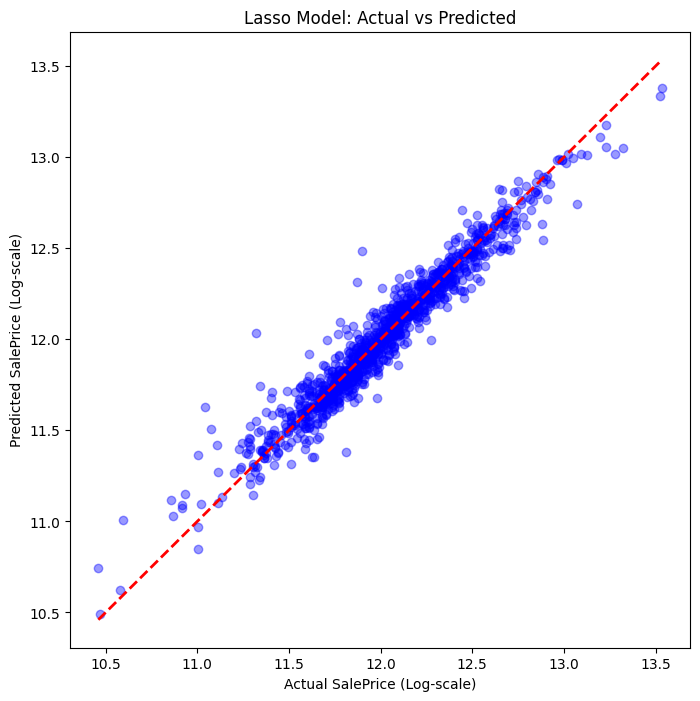

In [55]:
# 가장 성능이 좋았던 Lasso 모델로 학습
lasso.fit(X_train, y_train)
lasso_preds = lasso.predict(X_train)

# 시각화
plt.figure(figsize=(8, 8))
plt.scatter(y_train, lasso_preds, alpha=0.4, color='blue')

# 대각선 (완벽한 예측선) 추가
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
         'r--', lw=2)

plt.xlabel('Actual SalePrice (Log-scale)')
plt.ylabel('Predicted SalePrice (Log-scale)')
plt.title('Lasso Model: Actual vs Predicted')
plt.show()

데이터 포인트들이 빨간색 대각선에 매우 조밀하게 모여 있습니다.

로그 스케일에서 선형성을 잘 유지하고 있어, 이상치에 치우치지 않고 안정적인 예측을 하고 있음을 보여줍니다.

In [57]:
# 테스트 데이터(X_test)에 대한 예측 수행
final_preds_log = lasso.predict(X_test)

# 그 변환된 값을 원래 가격으로 복원 (np.expm1)
final_preds = np.expm1(final_preds_log)

# 제출용 데이터프레임 생성
# 저장해두었던 test_df의 Id를 사용합니다.
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": final_preds
})

# CSV 파일로 저장
submission.to_csv('submission_lasso.csv', index=False)

# 캐글 결과: 20887.51626

## 4단계: 하이퍼파라미터 튜닝 및 앙상블
모델의 세부 설정을 조정해 성능 극대화

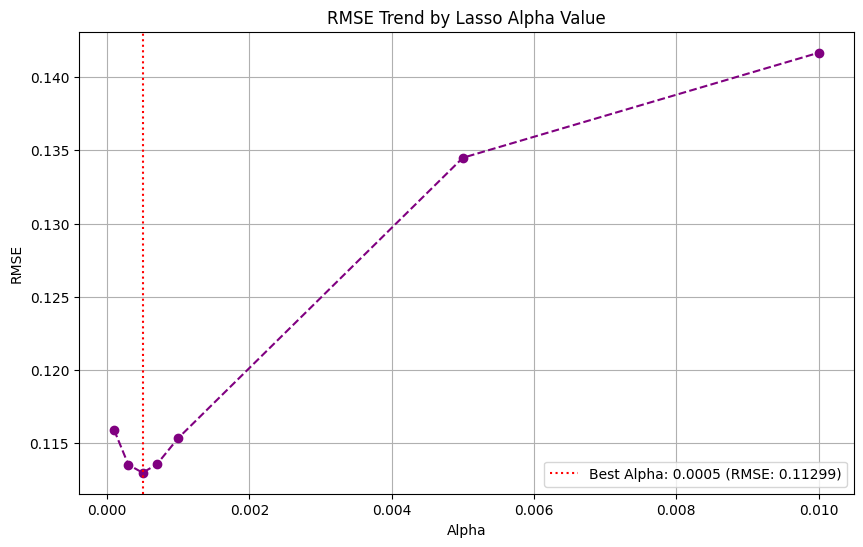

최적의 Alpha: 0.0005
최저 RMSE: 0.11299


In [60]:
# Lasso에 적합한 작은 alpha 범위 설정
alpha_range = np.array([0.0001, 0.0003, 0.0005, 0.0007, 0.001, 0.005, 0.01])
rmse_list = []

for a in alpha_range:
    # max_iter를 늘려 수렴 오류를 방지합니다.
    model = Lasso(alpha=a, max_iter=10000)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                    scoring="neg_mean_squared_error", cv=5))
    rmse_list.append(rmse.mean())

# 최적의 Alpha 값 자동 찾기
best_alpha = alpha_range[np.argmin(rmse_list)]
min_rmse = np.min(rmse_list)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, rmse_list, marker='o', color='purple', linestyle='--')

# 최적 지점에 수직선 표시
plt.axvline(best_alpha, color='red', linestyle=':',
            label=f'Best Alpha: {best_alpha} (RMSE: {min_rmse:.5f})')

plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE Trend by Lasso Alpha Value')
plt.legend()
plt.grid(True)
plt.show()

print(f"최적의 Alpha: {best_alpha}")
print(f"최저 RMSE: {min_rmse:.5f}")

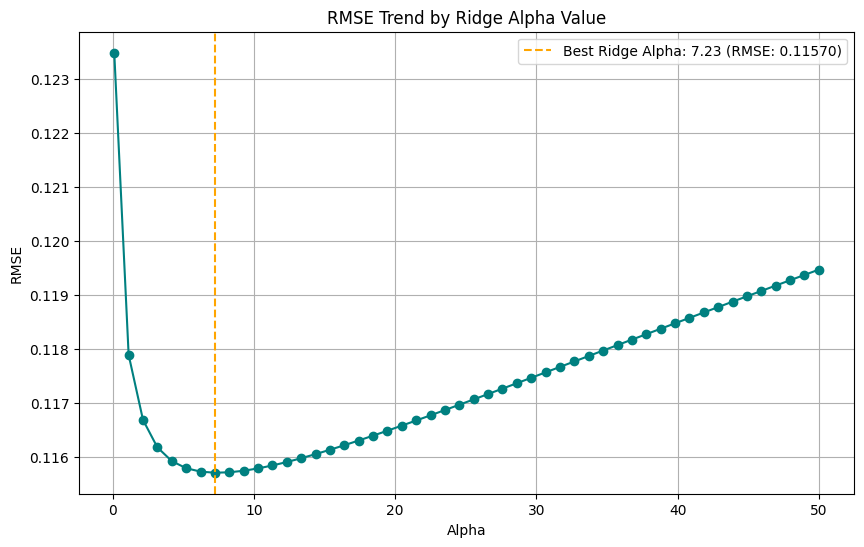

최적의 Ridge Alpha: 7.23
Ridge 최저 RMSE: 0.11570


In [62]:
from sklearn.linear_model import Ridge

# Ridge에 적합한 alpha 범위 설정 (0.1부터 50까지 50개 지점)
alpha_range = np.linspace(0.1, 50, 50)
ridge_rmse_list = []

for a in alpha_range:
    # Ridge 모델 정의
    model = Ridge(alpha=a)
    # 교차 검증 수행 (5-Fold)
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                    scoring="neg_mean_squared_error", cv=5))
    ridge_rmse_list.append(rmse.mean())

# 최적의 Alpha 및 최저 RMSE 계산
best_ridge_alpha = alpha_range[np.argmin(ridge_rmse_list)]
min_ridge_rmse = np.min(ridge_rmse_list)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(alpha_range, ridge_rmse_list, marker='o', color='teal', linestyle='-')

# 최적 지점에 수직선 표시
plt.axvline(best_ridge_alpha, color='orange', linestyle='--',
            label=f'Best Ridge Alpha: {best_ridge_alpha:.2f} (RMSE: {min_ridge_rmse:.5f})')

plt.xlabel('Alpha')
plt.ylabel('RMSE')
plt.title('RMSE Trend by Ridge Alpha Value')
plt.legend()
plt.grid(True)
plt.show()

print(f"최적의 Ridge Alpha: {best_ridge_alpha:.2f}")
print(f"Ridge 최저 RMSE: {min_ridge_rmse:.5f}")

In [63]:
# Ridge: 시각화 결과(image_4cea5b)에 따라 7.23 적용
model_ridge = Ridge(alpha=7.23)

# Lasso: 시각화 결과(image_4ce797)에 따라 0.0005 적용
model_lasso = Lasso(alpha=0.0005, random_state=42)

# XGBoost: 학습률을 낮추고(0.01) n_estimators를 높여 더 정밀하게 학습
model_xgb = XGBRegressor(
    n_estimators=3000,
    learning_rate=0.01,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)

# 모델 학습
model_ridge.fit(X_train, y_train)
model_lasso.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [67]:
# 테스트 데이터 예측
ridge_preds = model_ridge.predict(X_test)
lasso_preds = model_lasso.predict(X_test)
xgb_preds = model_xgb.predict(X_test)

# 4앙상블 (Blending)
# 현재 Lasso의 RMSE가 가장 낮으므로 Lasso에 비중을 더 많이 줌
final_log_preds = (lasso_preds * 0.45) + (ridge_preds * 0.25) + (xgb_preds * 0.30)

# 최종 결과 복원 및 제출
final_preds = np.expm1(final_log_preds)
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_preds})
submission.to_csv('submission_final_ensemble.csv', index=False)

# 캐글 결과: 20536.77638

In [68]:
# Lasso 비중 높여보기
w_lasso = 0.6
w_ridge = 0.2
w_xgb = 0.2

# 모델별 가중치 곱하기
final_log_preds = (lasso_preds * w_lasso) + \
                  (ridge_preds * w_ridge) + \
                  (xgb_preds * w_xgb)

final_preds = np.expm1(final_log_preds)
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_preds})

file_name = f'submission_ensemble_L{w_lasso}_R{w_ridge}_X{w_xgb}.csv'
submission.to_csv(file_name, index=False)
# 캐글 결과: 20570.25927

스테킹 기법 사용
- 메타모델 : Lasso
- LightGBM 추가

In [69]:
from sklearn.ensemble import StackingRegressor

# 개별 모델 정의
estimators = [
    ('lasso', model_lasso),
    ('ridge', model_ridge),
    ('xgb', model_xgb)
]

# 스태킹 모델 정의
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Lasso(alpha=0.0005),
    cv=5
)

# 학습 및 예측
stack_model.fit(X_train, y_train)
stack_preds = np.expm1(stack_model.predict(X_test))

In [74]:
from lightgbm import LGBMRegressor

# LightGBM 추가 예시
model_lgbm = LGBMRegressor(n_estimators=3000, learning_rate=0.01, max_depth=3, random_state=42, verbose=-1)
model_lgbm.fit(X_train, y_train)
lgbm_preds = model_lgbm.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [75]:
models_to_compare = {
    'Lasso': model_lasso,
    'Ridge': model_ridge,
    'XGBoost': model_xgb,
    'LightGBM': model_lgbm,
    'Stacking': stack_model
}

for name, model in models_to_compare.items():
    # 학습 및 교차 검증
    cv_score = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=5))
    print(f"{name:10} RMSE: {cv_score.mean():.5f}")

Lasso      RMSE: 0.11299
Ridge      RMSE: 0.11570
XGBoost    RMSE: 0.12080


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


LightGBM   RMSE: 0.12761
Stacking   RMSE: 0.11146


In [76]:
# LightGBM을 포함한 최종 estimators 구성
final_estimators = [
    ('lasso', model_lasso),
    ('ridge', model_ridge),
    ('xgb', model_xgb),
    ('lgbm', model_lgbm) # 단일 점수는 낮지만 앙상블 다양성을 위해 추가
]

# 최종 스태킹 모델
final_stack_model = StackingRegressor(
    estimators=final_estimators,
    final_estimator=Lasso(alpha=0.0005),
    cv=5,
    n_jobs=-1
)

# 전체 데이터 학습 및 예측
final_stack_model.fit(X_train, y_train)
stack_preds = final_stack_model.predict(X_test)

# 4. Blending으로 마무리 (가중치 전략)
# 스태킹 결과와 가장 강력했던 Lasso 결과를 0.8 : 0.2 정도로 섞어보세요.
final_log_preds = (stack_preds * 0.8) + (model_lasso.predict(X_test) * 0.2)

# 복원 및 제출 파일 생성
final_submission_preds = np.expm1(final_log_preds)
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_preds})
submission.to_csv('submission_stacking_lgbm_final.csv', index=False)

# 캐글 결과: 20390.43718

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [81]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [87]:
from catboost import CatBoostRegressor

# CatBoost 모델 정의
model_cat = CatBoostRegressor(
    iterations=3000,
    learning_rate=0.01,
    depth=4,
    l2_leaf_reg=3,
    loss_function='RMSE',
    random_seed=42,
    verbose=0
)

In [88]:
# 모든 모델을 포함한 최종 estimators
final_estimators = [
    ('lasso', model_lasso),
    ('ridge', model_ridge),
    ('xgb', model_xgb),
    ('cat', model_cat)
]

# 스태킹 모델 재구성
final_stack_model = StackingRegressor(
    estimators=final_estimators,
    final_estimator=Lasso(alpha=0.0005),
    cv=5,
    n_jobs=-1
)

In [89]:
# 학습 및 예측
final_stack_model.fit(X_train, y_train)
stack_preds_log = final_stack_model.predict(X_test)

# 최종 블렌딩
final_log_preds = (stack_preds_log * 0.85) + (model_lasso.predict(X_test) * 0.15)
final_preds = np.expm1(final_log_preds)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_preds})
submission.to_csv('submission_ultra_stacking.csv', index=False)

# 캐글 결과: 20420.12877


## 1단계. 데이터 이해 및 탐색 (EDA)
- Target 변수 확인
- 상관관계 분석
- 시각화

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터 불러오기
train_df_org = pd.read_csv('train.csv')
test_df_org = pd.read_csv('test.csv')
train_df = train_df_org.copy()
test_df = test_df_org.copy()

# 데이터 크기 확인
print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

train_df.head(3)

Train Data Shape: (1168, 81)
Test Data Shape: (292, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [2]:
print('\n전체 피처의 type \n', train_df.dtypes.value_counts())
isnull_series = train_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


전체 피처의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtCond          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
dtype: int64


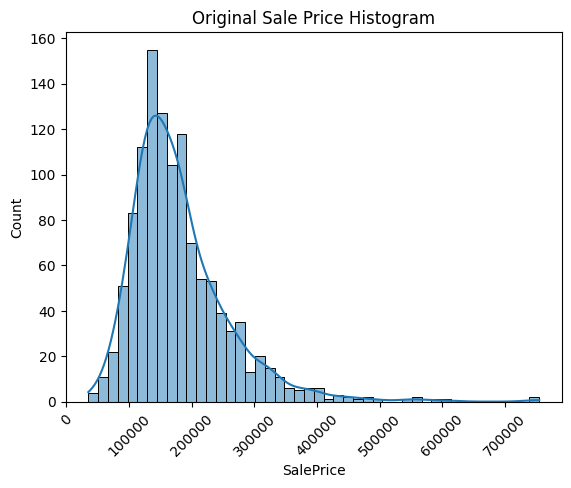

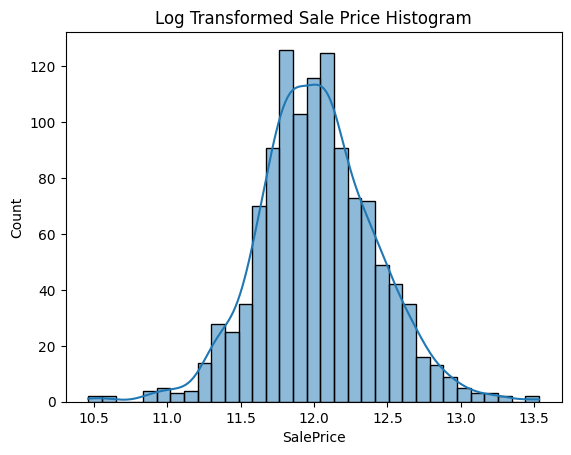

In [3]:
# 원본 SalePrice 히스토그램
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=45)
sns.histplot(train_df['SalePrice'], kde=True)
plt.show()

# 로그 변환 후 SalePrice 히스토그램
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(train_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

In [4]:
# SalePrice 로그 변환
original_SalePrice = train_df['SalePrice']
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

## 2단계: 데이터 전처리 (Data Cleaning)
- 이상치 확인 및 전처리
- 결측치 확인 및 전처리
- 인코딩

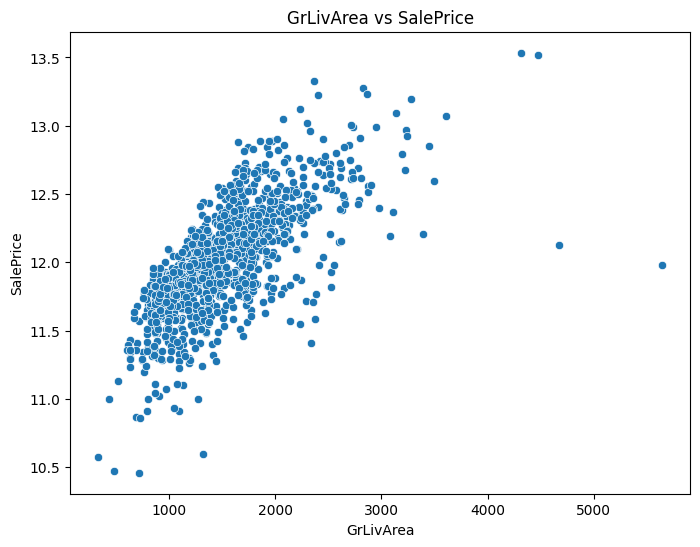

In [5]:
# 이상치 확인
# GrLivArea와 SalePrice의 관계
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_df['GrLivArea'], y=train_df['SalePrice'])
plt.title('GrLivArea vs SalePrice')
plt.show()

In [6]:
train_df = train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 12.5)].index)

In [7]:
ntrain = train_df.shape[0]
ntest = test_df.shape[0]

In [8]:
# 전체 데이터 통합
all_data = pd.concat((train_df, test_df)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)

In [9]:
# Null이 너무 많은 컬럼과 불필요한 컬럼 삭제
all_data.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [10]:
# 드롭하지 않는 숫자형 Null 컬럼은 평균값으로 대체
numeric_cols = all_data.select_dtypes(include=[np.number]).columns
all_data[numeric_cols] = all_data[numeric_cols].fillna(all_data[numeric_cols].mean())

In [11]:
# Null 값이 있는 피처명과 타입을 추출
null_column_count = all_data.isnull().sum()[all_data.isnull().sum() > 0]
print('## Null 피처의 Type :\n', all_data.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


Null값이 있는 문자형 피처 포함 원-핫-인코딩 변환

In [12]:
print('get_dummies() 수행 전 데이터 Shape:', all_data.shape)
all_data_ohe = pd.get_dummies(all_data)
print('get_dummies() 수행 후 데이터 Shape:', all_data_ohe.shape)

null_column_count = all_data_ohe.isnull().sum()[all_data_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', all_data_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1458, 74)
get_dummies() 수행 후 데이터 Shape: (1458, 268)
## Null 피처의 Type :
 Series([], dtype: object)


In [13]:
X_train = all_data_ohe[:ntrain]
X_test = all_data_ohe[ntrain:]
y_train = train_df.SalePrice

print(X_train.shape, y_train.shape)

(1166, 268) (1166,)


## 3단계: 모델 선택 및 학습 (Model Selection)

In [14]:
# 선형 회귀 모델 학습/예측/평가 함수 정의
def get_rmse(model):
    pred = model.predict(X_val)
    mse = mean_squared_error(y_val, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, ' 로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 학습 데이터(X_train)를 다시 학습용과 검증용으로 쪼개기
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=156
)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train_split, y_train_split)

ridge_reg = Ridge()
ridge_reg.fit(X_train_split, y_train_split)

lasso_reg = Lasso()
lasso_reg.fit(X_train_split, y_train_split)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression  로그 변환된 RMSE: 0.126
Ridge  로그 변환된 RMSE: 0.122
Lasso  로그 변환된 RMSE: 0.171


[np.float64(0.12596878582557802),
 np.float64(0.12204637037912754),
 np.float64(0.17074433331581423)]

In [16]:
# 회귀 계수 상위 10개, 하위 10개를 추출하는 함수
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 생성. index는 피처명
    coef = pd.Series(model.coef_, index=X_train.columns)

    # + 상위 10개, - 하위 10개 추출
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

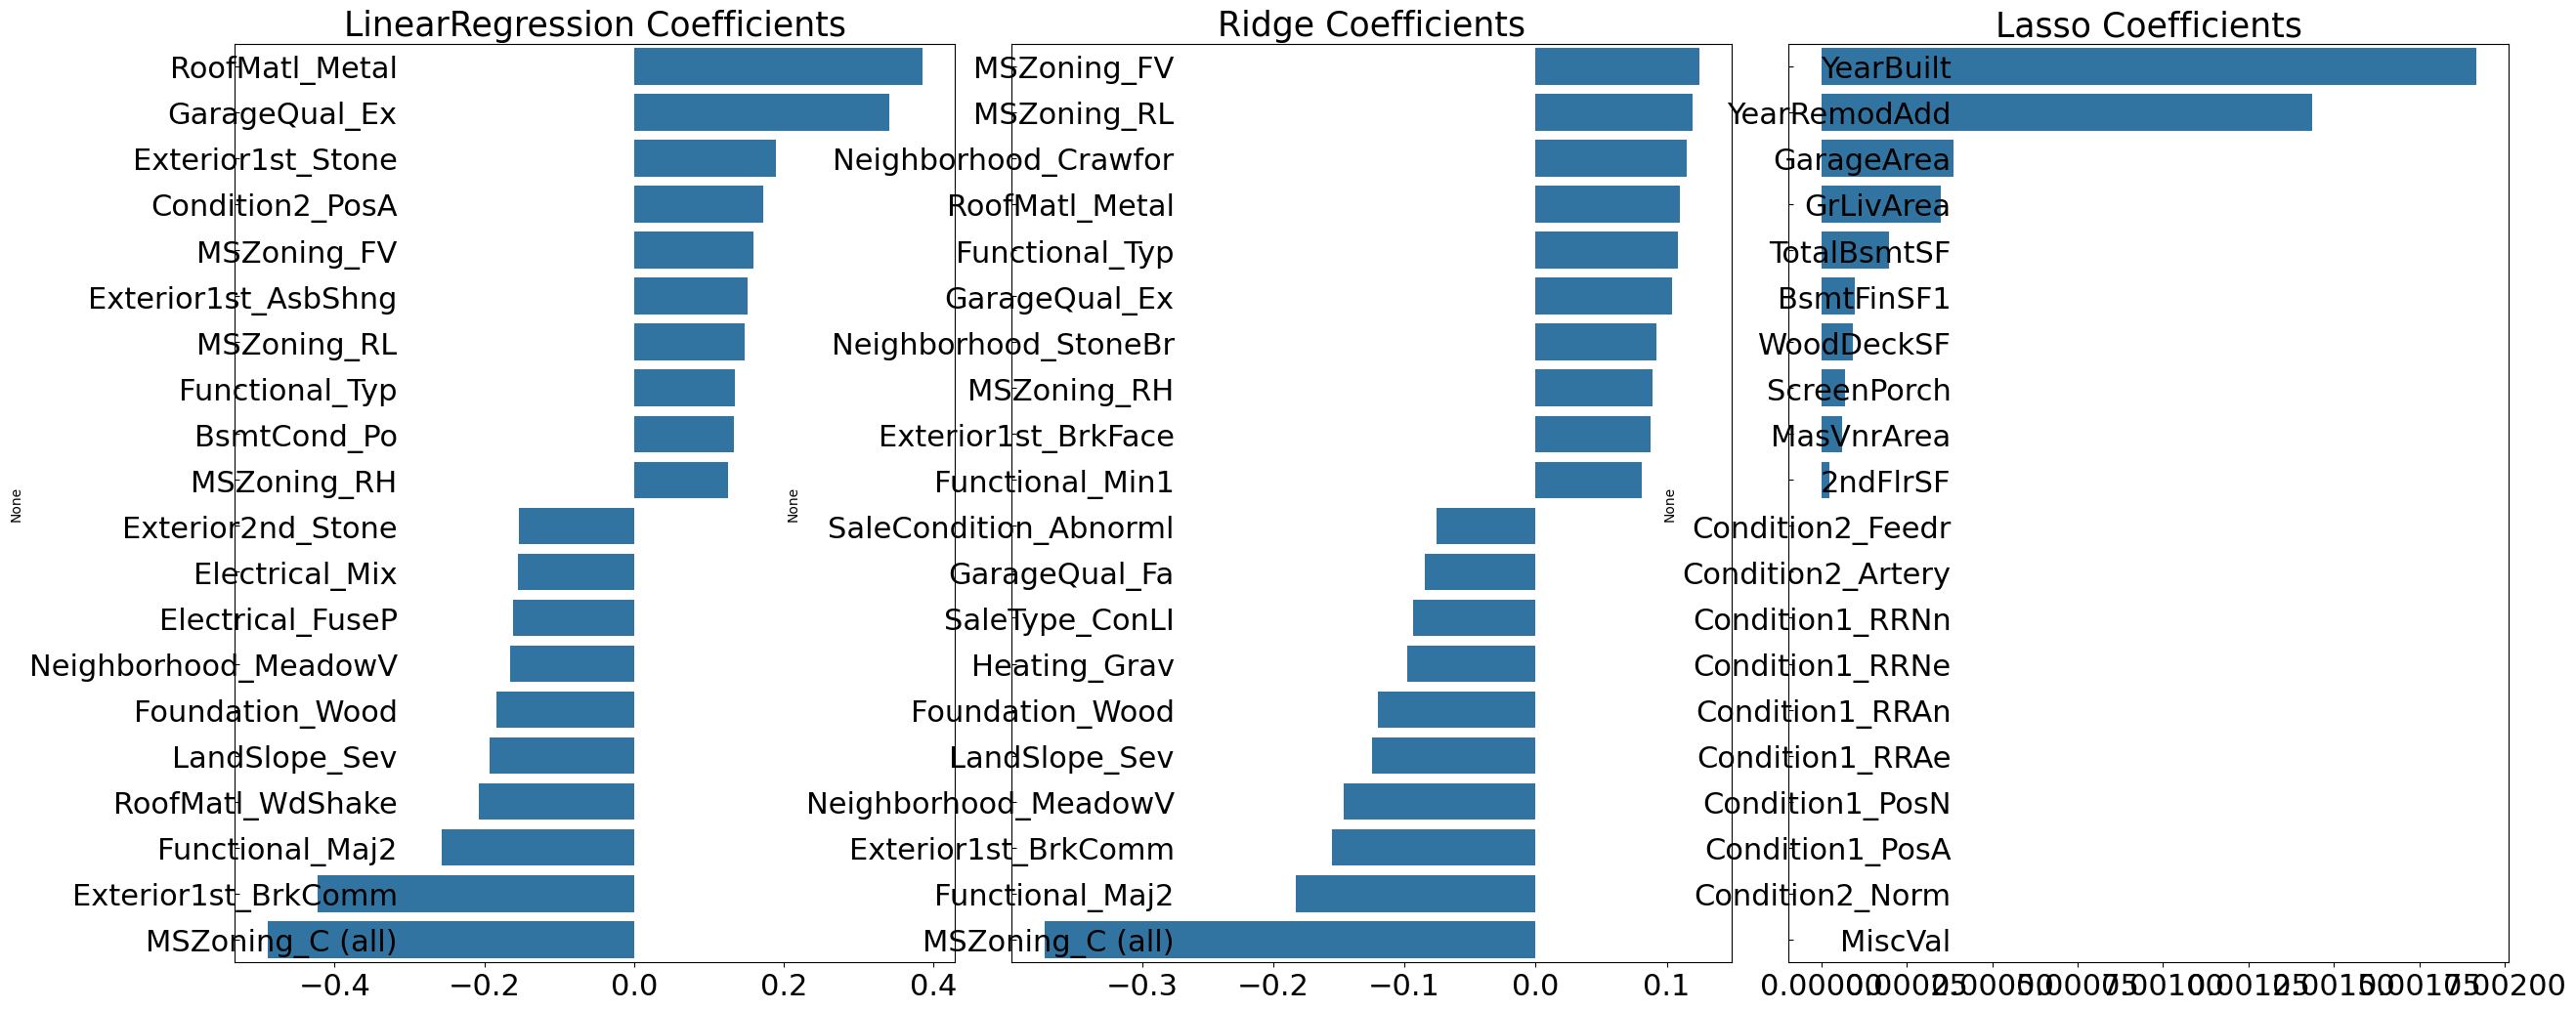

In [17]:
# 여러 모델의 회귀 계수를 한 번에 시각화하는 함수
def visualize_coefficient(models):
    # 3개 모델 시각화를 위한 subplot 생성
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()

    for i_num, model in enumerate(models):
        # 상위/하위 10개 계수 추출 후 결합
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])

        # 시각화 설정
        axs[i_num].set_title(model.__class__.__name__ + ' Coefficients', size=25)
        axs[i_num].tick_params(axis="y", direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)

        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 모델 리스트 생성 및 시각화 실행
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

Lasso Coefficients
전체적으로는 회귀 계수의 값이 작고 YearBuilt(건축 연도)와 YearRemodAdd(리모델링 연도)가 압도적으로 높은 양의 계수를 가집니다.

Ridge Coefficients
지역적 영향이 가격을 결정하는 큰 요인이 됩니다.
- MSZoning: Identifies the general zoning classification of the sale.
  - A	Agriculture
  - C	Commercial
  - FV	Floating Village Residential
  - I	Industrial
  - RH	Residential High Density
  - RL	Residential Low Density
  - RP	Residential Low Density Park
  - RM	Residential Medium Density

Linear Regression Coefficients
RoofMatl_Metal(금속 지붕)이나 GarageQual_Ex(최고급 차고 품질) 등이 높은 계수를 가집니다.

In [18]:
# 교차 검증(Cross Validation)을 통한 RMSE 측정
# 데이터를 5개로 나누어(cv=5) 모델의 일반화 성능을 더 정확하게 측정
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 교차 검증 수행 (MSE에 -1을 곱해 RMSE 계산)
        rmse_list = np.sqrt(-cross_val_score(model, X_train_split, y_train_split,
                                             scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)

        print('\n{0} CV RMSE 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(rmse_avg, 3)))

# 릿지, 라쏘 모델의 교차 검증 수행
models = [ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


Ridge CV RMSE 리스트: [0.107 0.12  0.148 0.129 0.115]
Ridge CV 평균 RMSE 값: 0.124

Lasso CV RMSE 리스트: [0.148 0.174 0.189 0.199 0.172]
Lasso CV 평균 RMSE 값: 0.176


In [38]:
# GridSearchCV를 이용한 하이퍼 파라미터(Alpha) 최적화
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_train_split, y_train_split)

    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha: {2}'.format(model.__class__.__name__,
                                                                    np.round(rmse, 4), grid_model.best_params_))

# 최적 파라미터 찾기 실행
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1175, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1179, 최적 alpha: {'alpha': 0.001}


LinearRegression  로그 변환된 RMSE: 0.122
Ridge  로그 변환된 RMSE: 0.115
Lasso  로그 변환된 RMSE: 0.111


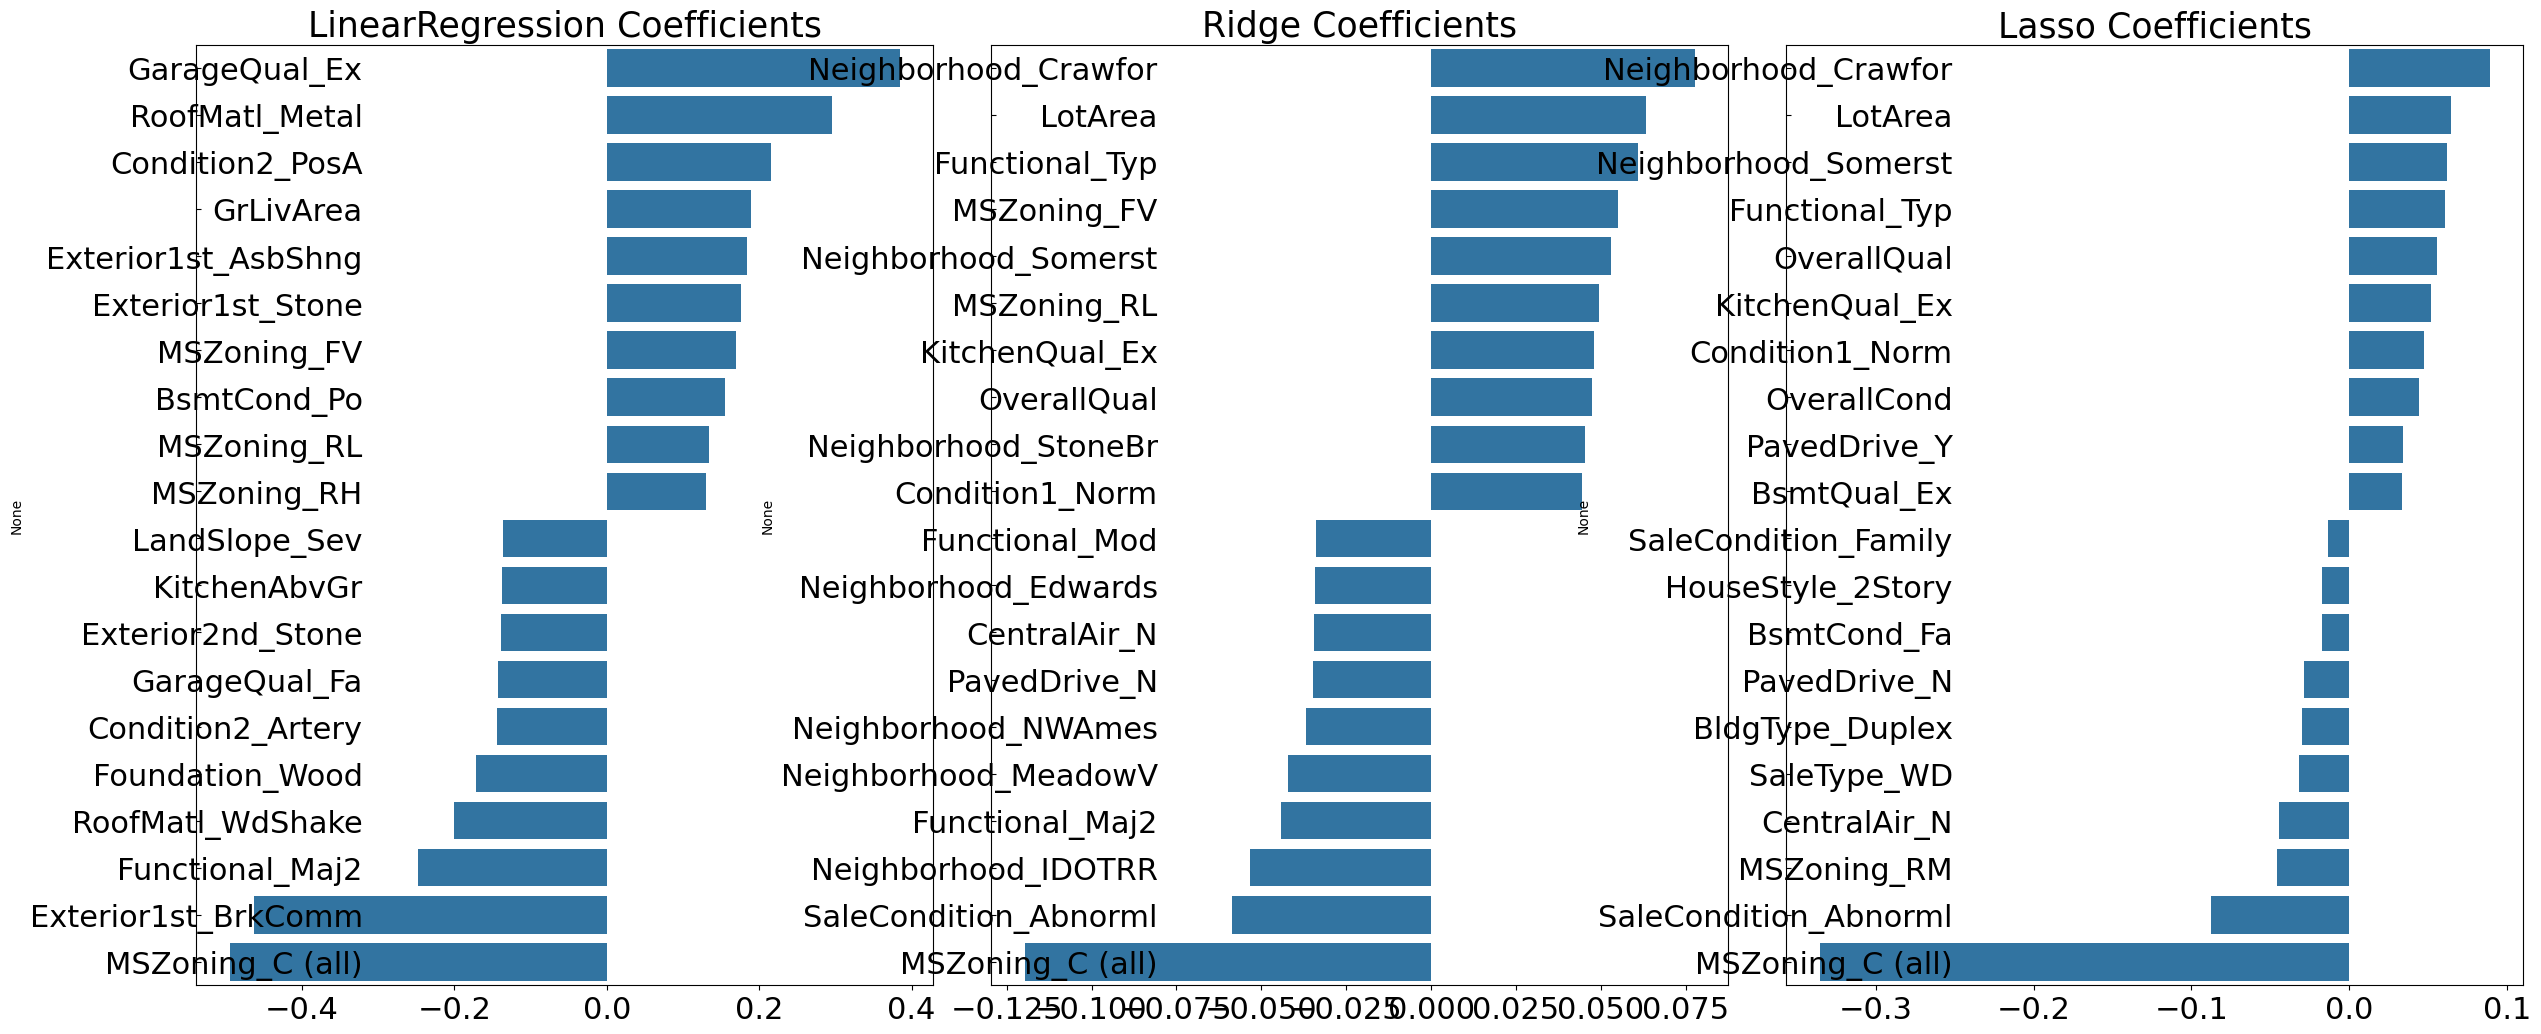

In [39]:
# 최적화된 alpha 값 적용 (예시: ridge 12, lasso 0.001)
lr_reg = LinearRegression()
lr_reg.fit(X_train_split, y_train_split)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train_split, y_train_split)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train_split, y_train_split)

# 모든 모델의 RMSE 및 회귀 계수 시각화 재실행
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [40]:
# 데이터 분포의 왜곡 확인
from scipy.stats import skew

# 숫자형 컬럼 index 객체 추출
features_index = all_data.dtypes[all_data.dtypes != 'object'].index
skew_features = all_data[features_index].apply(lambda x : skew(x))

# 왜도 정도가 1 이상인 컬럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

PoolArea         15.501716
3SsnPorch         7.721468
LowQualFinSF      7.447271
MiscVal           5.161462
BsmtHalfBath      3.925827
KitchenAbvGr      3.862290
ScreenPorch       3.144400
BsmtFinSF2        2.518628
EnclosedPorch     2.107795
dtype: float64


In [41]:
all_data[skew_features_top.index] = np.log1p(all_data[skew_features_top.index])

In [42]:
# 왜곡된 피처 로그 변환 후 다시 원-핫 인코딩 적용
print('get_dummies() 수행 전 데이터 Shape:', all_data.shape)
all_data_ohe = pd.get_dummies(all_data)
print('get_dummies() 수행 후 데이터 Shape:', all_data_ohe.shape)

get_dummies() 수행 전 데이터 Shape: (1458, 74)
get_dummies() 수행 후 데이터 Shape: (1458, 268)


In [43]:
X_train = all_data_ohe[:ntrain]
X_test = all_data_ohe[ntrain:]
y_train = train_df.SalePrice

print(X_train.shape, y_train.shape)

(1166, 268) (1166,)


In [44]:
# 최적 파라미터 찾기 실행
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10] }

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1175, 최적 alpha: {'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1179, 최적 alpha: {'alpha': 0.001}


LinearRegression  로그 변환된 RMSE: 0.122
Ridge  로그 변환된 RMSE: 0.115
Lasso  로그 변환된 RMSE: 0.111


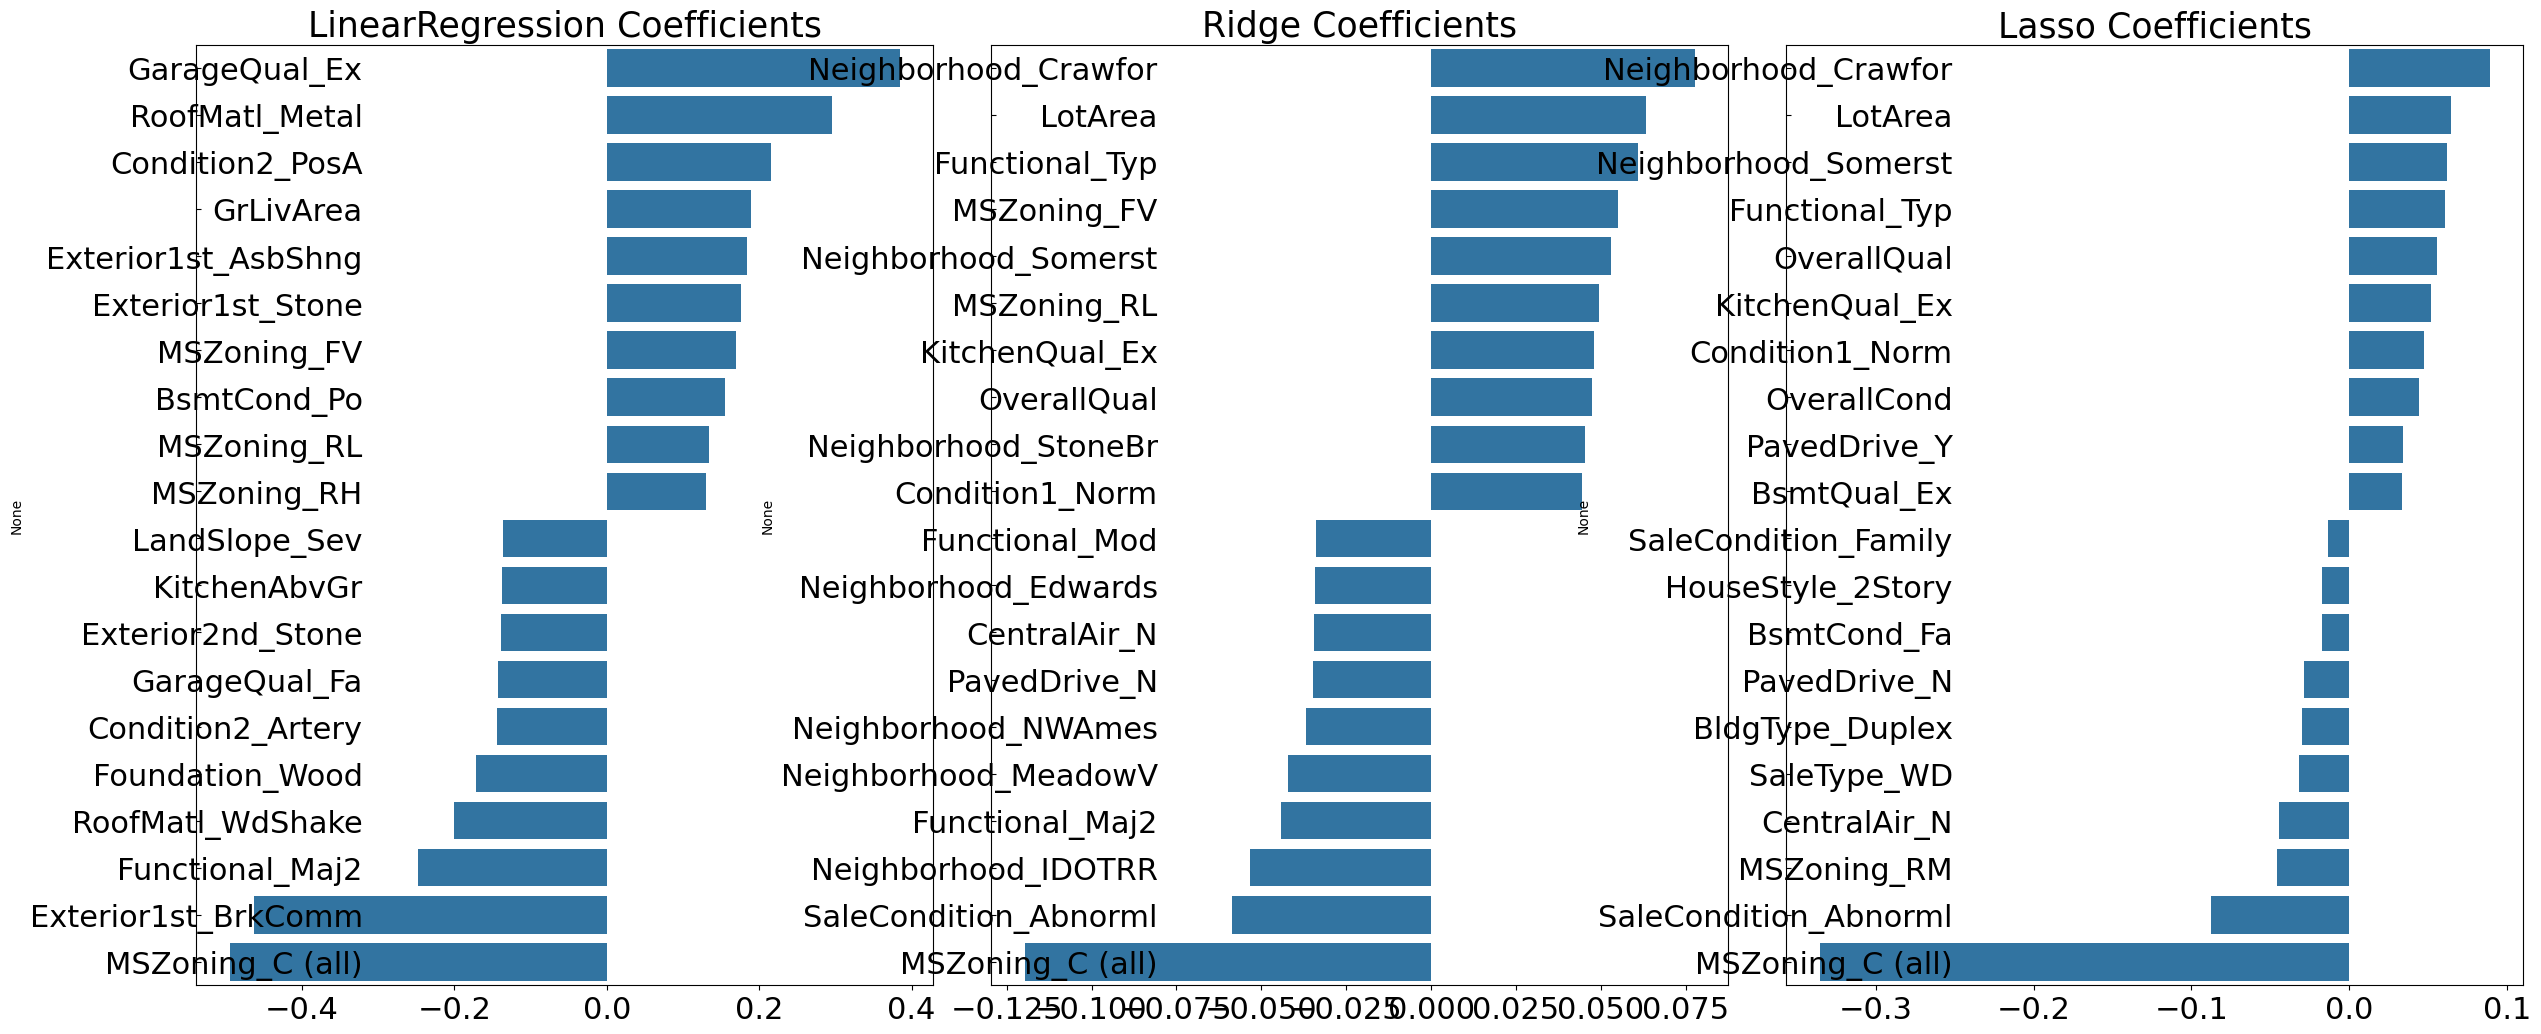

In [32]:
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=156
)

# 최적화된 alpha 값 적용
lr_reg = LinearRegression()
lr_reg.fit(X_train_split, y_train_split)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train_split, y_train_split)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train_split, y_train_split)

# 모든 모델의 RMSE 및 회귀 계수 시각화 재실행
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [33]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
print_best_params(lgbm_reg, lgbm_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1351, 최적 alpha: {'n_estimators': 1000}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000720 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 745, number of used features: 147
[LightGBM] [Info] Start training from score 12.030249
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 745, number of used features: 145
[LightG

LinearRegression  로그 변환된 RMSE: 0.175
Ridge  로그 변환된 RMSE: 0.1
Lasso  로그 변환된 RMSE: 0.102


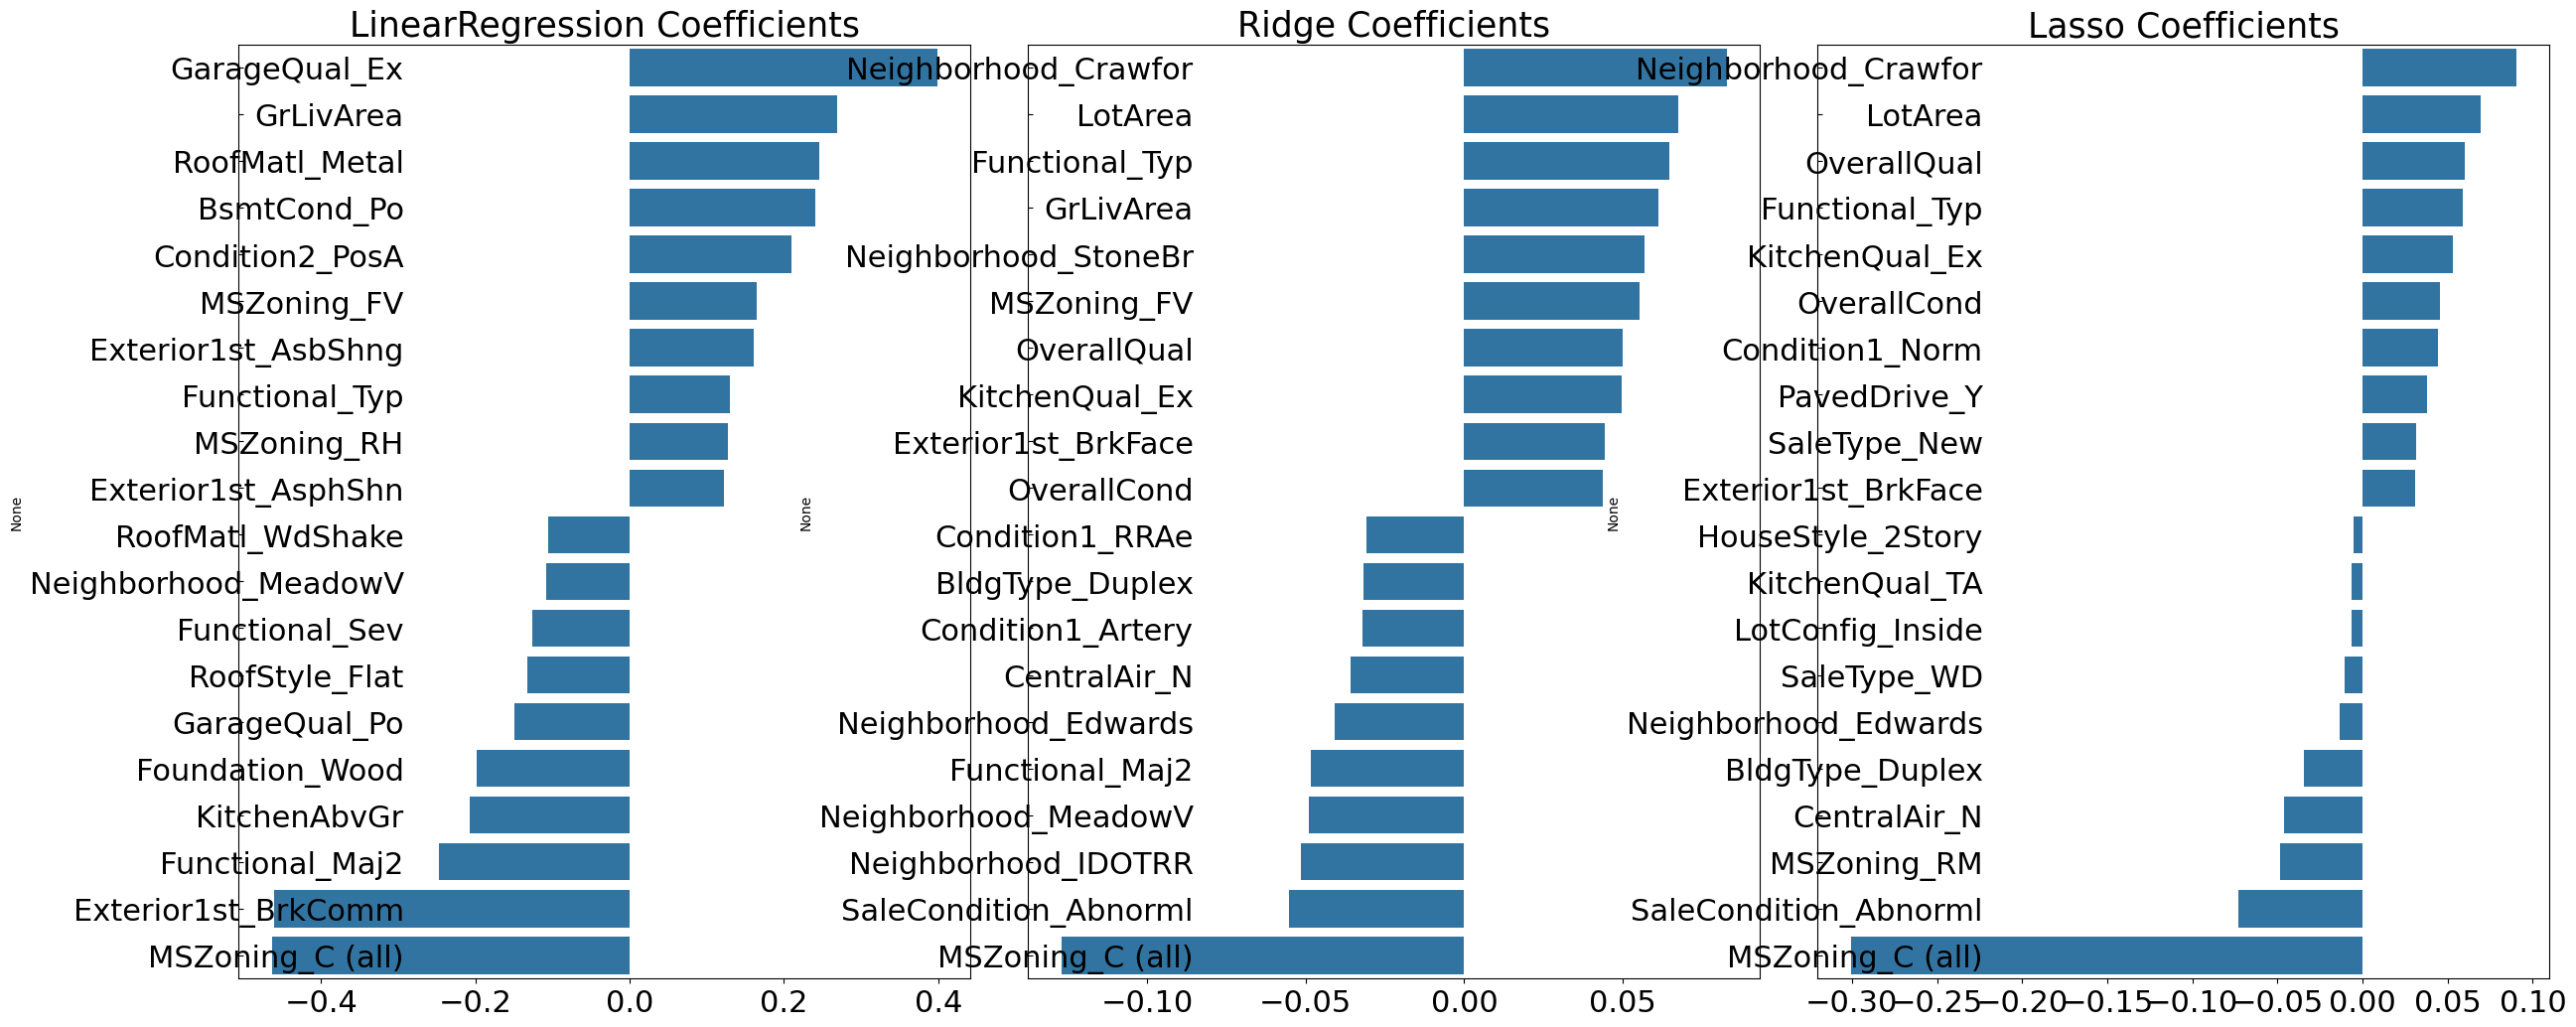

In [45]:
# 최적화된 alpha 값 적용 (예시: ridge 12, lasso 0.001)
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 및 회귀 계수 시각화 재실행
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)
visualize_coefficient(models)

In [34]:
# 개별 모델의 학습
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.001)

In [ ]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.3 * ridge_pred + 0.7 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined.csv', index=False)

# 캐글 결과: 19810.40751

In [35]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.2 * ridge_pred + 0.8 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined.csv', index=False)

# 캐글 결과: 19874.96150

In [36]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.4 * ridge_pred + 0.6 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined_0.6.csv', index=False)

# 캐글 결과: 19760.00521

In [37]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.5 * ridge_pred + 0.5 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined_0.5.csv', index=False)

# 캐글 결과: 19723.98432

In [47]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.6 * ridge_pred + 0.4 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined_0.4.csv', index=False)

# 캐글 결과: 19637.79687

In [51]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.7 * ridge_pred + 0.3 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined_0.3.csv', index=False)

# 캐글 결과: 19632.40679

In [52]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 최종 테스트 예측값 혼합
final_pred = 0.8 * ridge_pred + 0.2 * lasso_pred

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(final_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_combined_0.2.csv', index=False)

# 캐글 결과: 19643.06639

In [54]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.6 MB/s eta 0:00:00


In [55]:
from sklearn.ensemble import StackingRegressor
from catboost import CatBoostRegressor

# 개별 모델 정의
estimators = [
    ('lasso', Lasso(alpha=0.001)),
    ('ridge', Ridge(alpha=12)),
    ('xgb', XGBRegressor(n_estimators=500, learning_rate=0.1, max_depth=3, n_jobs=-1)), # 깊이와 트리수 조절
    ('lgbm', LGBMRegressor(n_estimators=500, learning_rate=0.1, num_leaves=4, verbose=-1, n_jobs=-1)),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.1, depth=4, verbose=0, thread_count=-1))
]

# 스테킹 모델 정의 (메타 모델: Lasso)
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Lasso(alpha=0.001),
    cv=3,
    n_jobs=-1
)

# 전체 데이터(X_train)로 최종 학습
stack_model.fit(X_train, y_train)

# 테스트 데이터 예측 및 로그 변환 복원
stack_preds_log = stack_model.predict(X_test)
final_preds = np.expm1(stack_preds_log)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_preds})
submission.to_csv('submission_final_stacking_try.csv', index=False)

# 캐글 결과: 19808.92009

In [59]:
# 개별 모델 정의
estimators = [
    ('lasso', Lasso(alpha=0.001)),
    ('ridge', Ridge(alpha=12)),
    ('lgbm', LGBMRegressor(n_estimators=500, learning_rate=0.1, num_leaves=4, verbose=-1, n_jobs=-1)),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.1, depth=4, verbose=0, thread_count=-1))
]

# 스테킹 모델 정의 (메타 모델: Lasso)
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Lasso(alpha=0.001),
    cv=5,
    n_jobs=-1
)

# 전체 데이터(X_train)로 최종 학습
stack_model.fit(X_train, y_train)

# 테스트 데이터 예측 및 로그 변환 복원
stack_preds_log = stack_model.predict(X_test)
final_preds = np.expm1(stack_preds_log)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_preds})
submission.to_csv('submission_final_stacking_lasso.csv', index=False)

# 캐글 결과: 20041.65749

In [60]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
lasso_pred = lasso_reg.predict(X_test)

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(lasso_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_lasso_pred.csv', index=False)

# 캐글 결과: 19995.02334

In [61]:
# 캐글 제출을 위한 진짜 테스트 데이터(X_test) 예측
ridge_pred = ridge_reg.predict(X_test)

# 로그 변환된 값을 원래 SalePrice로 복원 (np.exp)
# 타깃값을 처음에 np.log1p()로 변환했으므로 복원 필수입니다!
final_submission_pred = np.expm1(ridge_pred)

# 제출 파일 생성
submission = pd.DataFrame({"Id": test_df["Id"], "SalePrice": final_submission_pred})
submission.to_csv('submission_ridge_pred.csv', index=False)

# 캐글 결과: 19713.09198